# Project Simulation & Optimization
Given is a rod with cross-section $A$, thermal conductivity $\lambda$ with a constant heat supply $Q_0$ along the rod.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The temperature profile is described by the differential equation:  
$T'' + \dfrac{Q_0}{\lambda\,A}=0$  
Integrating and using the boundary conditions $T(0)=0$ and $T(l)=0$ yields:  
$T = -\dfrac{Q_0}{2\,\lambda\,A}\,x^2 + \dfrac{Q_0}{2\,\lambda\,A}\,x$

In [2]:
Q0 = 15 # J/m^2s
lamb = 5 # J/°Cms
A = 1e-6 # m^2
l = 1 # m

### analytical Function of $T$

Text(0, 0.5, 'temperature on beam in °C')

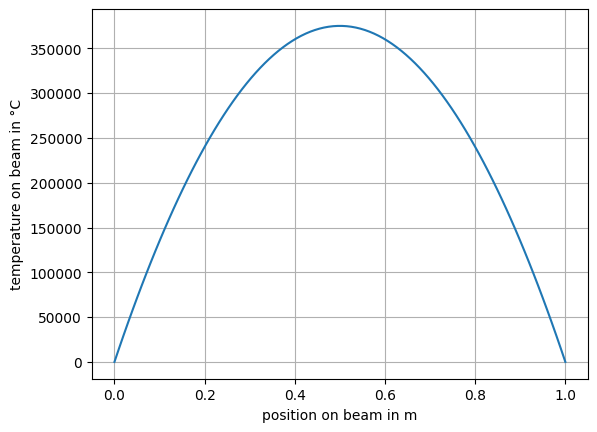

In [5]:
def T(x):
    return -Q0/(2*lamb*A)*x**2 + Q0/(2*lamb*A)*x

def T_dd(x):
    return np.ones_like(x)*-Q0/(2*lamb*A)

x = np.linspace(0, 1, 100)
plt.plot(x, T(x))
plt.grid()
plt.xlabel("position on beam in m")
plt.ylabel("temperature on beam in °C")

### finite difference approximation of $T''$

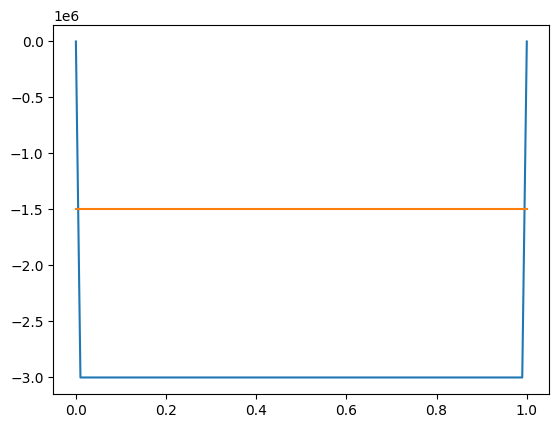

In [6]:
T_dd_app = np.zeros_like(x, dtype=float)
h = x[1]-x[0]
T_dd_app[1:-1] = (T(x[1:-1]+h) - 2*T(x[1:-1]) + T(x[1:-1]-h)) / h**2

plt.plot(x,T_dd_app)
plt.plot(x, T_dd(x))
